Text(0.5, 0, 'Mês/Ano')

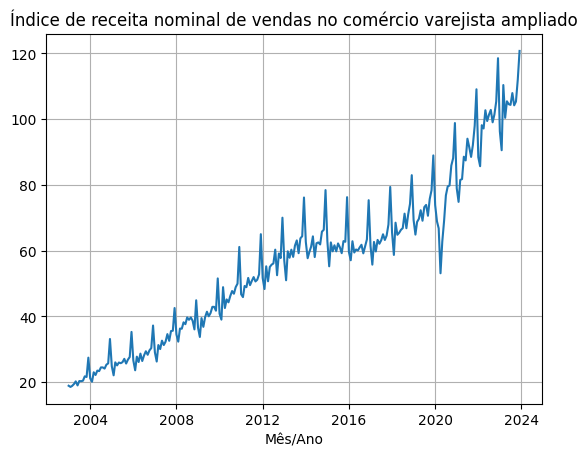

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Importação de dados (já coletados com o sidraR pelo R)

pmc = pd.read_csv('PMC_VOLUME.cvs')
dados = pmc['Valor']
# Dividindo para fazer as previsões 

serie = dados.iloc[0:len(dados)-13]
datas = pd.date_range(start='2003-01', periods=len(serie), freq='MS')
serie.index = datas

# Gráfico
plt.figure()
plt.plot(serie)
plt.grid(True)
plt.title("Índice de receita nominal de vendas no comércio varejista ampliado")
plt.xlabel("Mês/Ano")


In [2]:
# Modelando a tendência da Série:
import numpy as np
n = len(serie) 
t = np.arange(1 , n+1 , 1)

from sklearn.linear_model import LinearRegression

trend = {'Y' : serie , 'X' : t , 'X2':t**2 , 'X3':t**3}
trend = pd.DataFrame(trend)

# Tendência Linear
t1 = LinearRegression()
t1.fit(X = trend[['X']] , y = trend['Y'])
trend['Tendencia'] = t1.predict(trend[['X']])

#Tendência quadrática
t2 = LinearRegression()
t2.fit(trend[['X', 'X2']], trend['Y'])
trend['Tendencia 2'] = t2.predict(trend[['X', 'X2']])

#Tendência Cúbica

t3 = LinearRegression()
t3.fit(trend[['X','X2','X3']] , trend['Y'])
trend['Tendencia 3'] = t3.predict(trend[['X','X2','X3']])

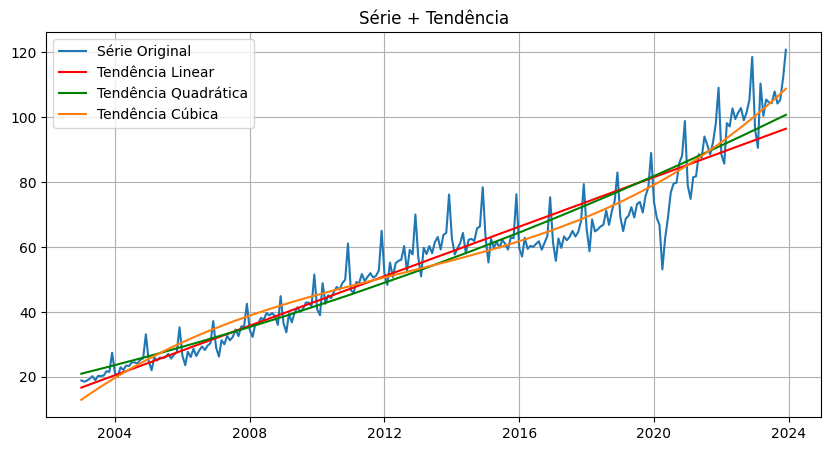

In [3]:
# Gráfico

plt.figure(figsize=(10,5))
plt.plot(datas, trend['Y'], label='Série Original')
plt.plot(datas, trend['Tendencia'], label='Tendência Linear', color='red')
plt.plot(datas, trend['Tendencia 2'], label='Tendência Quadrática', color='green')
plt.plot(datas, trend['Tendencia 3'] , label='Tendência Cúbica')
plt.legend()
plt.title("Série + Tendência")
plt.grid(True)
plt.show()   

In [4]:
# calcular AIC
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS

aic_modelos= [OLS(serie , add_constant(trend.iloc[:,[1]])).fit() ,
              OLS(serie , add_constant(trend.iloc[:,[1,2]])).fit(),
              OLS(serie , add_constant(trend.iloc[:,[1,2,3]])).fit()]

aic = [aic_modelos[0].aic , aic_modelos[1].aic, aic_modelos[2].aic]
aic

[np.float64(1702.4174126844168),
 np.float64(1684.5938829072247),
 np.float64(1626.818374407647)]

In [5]:
from statsmodels.tsa.stattools import adfuller
# Remoção da Tendência e trabalhar com a sazonalidade:
serie_2 = serie - trend['Tendencia 3']

# Diagnóstico de estacionariedade
def diagnostico_estacionariedade(serie):
    print("\n--- Teste de Dickey-Fuller aumentado ---")
    resultado = adfuller(serie)
    print(f"ADF Statistic: {resultado[0]:.4f}")
    print(f"p-value: {resultado[1]:.4f}")
    for key, value in resultado[4].items():
        print(f"Critério {key}: {value:.4f}")

diagnostico_estacionariedade(serie_2)


--- Teste de Dickey-Fuller aumentado ---
ADF Statistic: -2.1445
p-value: 0.2270
Critério 1%: -3.4580
Critério 5%: -2.8737
Critério 10%: -2.5733


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(serie)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, find_peaks
from scipy.optimize import curve_fit

# Função senoidal
def modelo_seno(t, a, b, c, d):
    return a * np.sin(b * t * 2 * np.pi + d) + c

# Função para ajustar e remover 1 componente
def ajustar_remover_seno(st, t, freq):
    a0 = (max(st) - min(st)) / 2
    c0 = (max(st) + min(st)) / 2
    b0 = freq
    p0 = [a0, b0, c0, 1]

    params, _ = curve_fit(modelo_seno, t, st, p0=p0)
    seno = modelo_seno(t, *params)
    return seno, params

# Pipeline completo para remover N frequências
def remover_frequencias(serie, datas, n_componentes=6, altura_pico=1.0):
    st = serie.values
    t = np.arange(len(st))
    sinais = []
    modelos = []

    for i in range(n_componentes):
        # Espectro
        freqs, power = periodogram(st)
        peaks, _ = find_peaks(power, height=altura_pico)
        top_peaks = peaks[np.argsort(power[peaks])[-n_componentes:]]
        fp = freqs[top_peaks]

        # Foco na frequência desejada
        freq_alvo = fp[i]
        seno, params = ajustar_remover_seno(st, t, freq_alvo)
        sinais.append((st.copy(), freqs, power, top_peaks, freq_alvo, seno))
        modelos.append(params)
        st = st - seno  # remove componente atual

    return sinais, st, modelos

# Exibir resultados em gráfico
def plotar_componentes(sinais, datas, serie_original):
    n = len(sinais)
    fig, axs = plt.subplots(n, 2, figsize=(20, 20))

    for i, (st, freqs, power, top_peaks, freq, seno) in enumerate(sinais):
        # Espectro
        axs[i, 0].plot(freqs, power)
        axs[i, 0].plot(freqs[top_peaks], power[top_peaks], 'ro')
        axs[i, 0].set_title(f"Espectro {i+1} - Freq. retirada: {freq:.4f}")

        # Sinal ajustado
        axs[i, 1].plot(datas, st, label='Original')
        axs[i, 1].plot(datas, seno, color='red', label='Componente Senoidal')
        axs[i, 1].set_title(f"Série vs Componente {i+1}")
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Filtrando sinais
sinais, serie_final, modelos = remover_frequencias(serie_2, datas, n_componentes=20)
#plotar_componentes(sinais, datas, serie_2)


In [9]:
# Modelando a última parte, a estocástica

from statsmodels.tsa.arima.model import ARIMA

# Ajustar modelo ARIMA manualmente, por exemplo (1,1,1)
model = ARIMA(serie_final, order=(1,0,2) )
fit = model.fit()

# predição
predict = fit.predict(start=0, end=len(serie_final)-1)



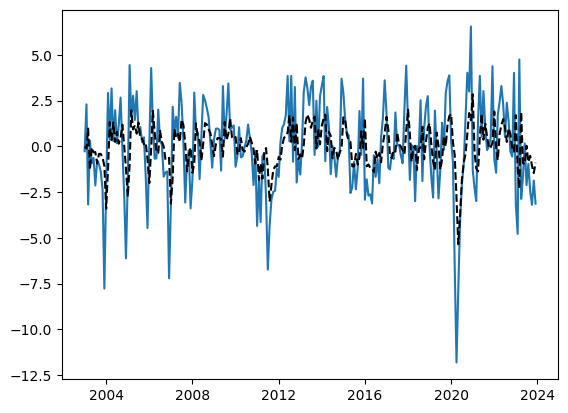

In [11]:
plt.figure()
plt.plot(datas, serie_final )
plt.plot(datas , predict , 'k--')

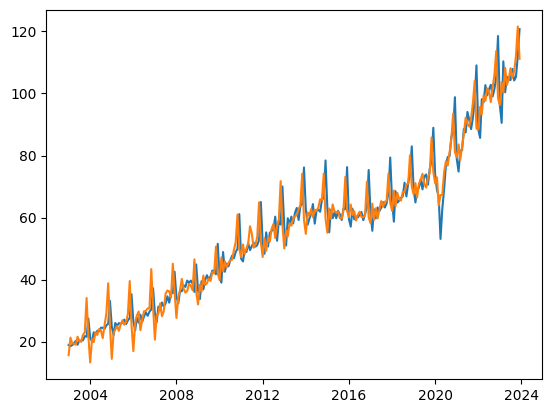

In [12]:
# Recriar os senos removidos
componentes = [modelo_seno(t, *p) for p in modelos]
soma_componentes = np.sum(componentes, axis=0)

# Reconstruir a série
serie_reconstruida = predict + soma_componentes + trend['Tendencia 3']

plt.figure()
plt.plot(serie)
plt.plot(datas, serie_reconstruida)

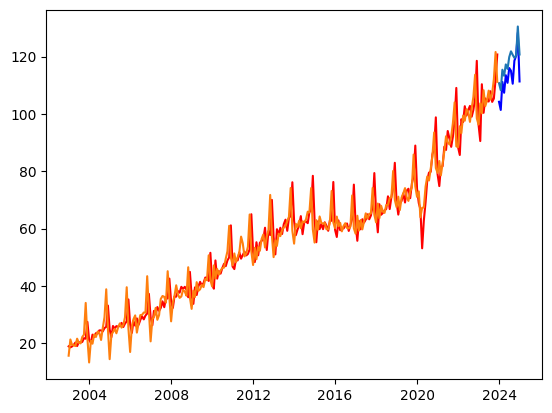

In [13]:
# previsão
t_new = np.arange(252, 265)
new_x = pd.DataFrame({'X': t_new, 'X2': t_new**2, 'X3': t_new**3})
new_y = pd.DataFrame({'Y': dados[len(dados)-13:len(dados)]})
datas_new = pd.date_range(start='2024-01', periods=len(t_new), freq='MS')

t3.predict(new_x)

componentes_new = [modelo_seno(t_new, *p) for p in modelos]
soma_componentes_new = np.sum(componentes_new, axis=0)
randon_new = fit.predict(start=t_new[0], end=max(t_new))
predicoes = randon_new + soma_componentes_new + t3.predict(new_x)


plt.figure()
plt.plot(datas, serie , color = 'red')
plt.plot(datas_new, new_y.values , color = 'blue')
plt.plot(datas_new, predicoes)
plt.plot(datas, serie_reconstruida)


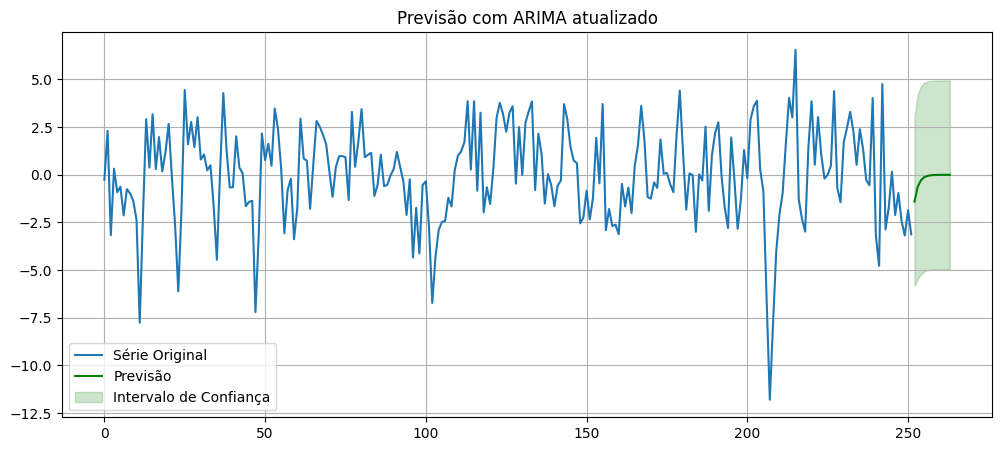

(252   -1.415829
 253   -0.643636
 254   -0.295933
 255   -0.139370
 256   -0.068872
 257   -0.037128
 258   -0.022835
 259   -0.016399
 260   -0.013501
 261   -0.012196
 262   -0.011608
 263   -0.011344
 Name: predicted_mean, dtype: float64,
       lower y   upper y
 252 -5.820229  2.988571
 253 -5.481076  4.193803
 254 -5.219682  4.627816
 255 -5.081849  4.803110
 256 -5.015778  4.878034
 257 -4.985219  4.910962
 258 -4.971296  4.925626
 259 -4.964994  4.932196
 260 -4.962150  4.935149
 261 -4.960869  4.936478
 262 -4.960293  4.937077
 263 -4.960034  4.937347)

In [15]:

def prever_com_modelo_atualizado(dados, n_forecast=12):
    modelo = ARIMA(dados, order=(1, 1, 1))
    fitted = modelo.fit()
    previsao = fitted.get_forecast(steps=n_forecast)
    pred = previsao.predicted_mean
    ic = previsao.conf_int()

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(dados.index, dados, label='Série Original')
    plt.plot(pred.index, pred, color='green', label='Previsão')
    plt.fill_between(pred.index, ic.iloc[:, 0], ic.iloc[:, 1], color='green', alpha=0.2, label='Intervalo de Confiança')
    plt.legend()
    plt.title("Previsão com ARIMA atualizado")
    plt.grid(True)
    plt.show()

    return pred, ic

prever_com_modelo_atualizado(pd.Series(serie_final))